In [1]:
%matplotlib inline
import os
import logging
import sys
import numpy as np
import matplotlib.pyplot as plt

import nems
import nems.initializers
import nems.priors
import nems.utils
import nems.xforms as xforms
import nems.db as nd
import nems.recording as recording
from nems.xform_helper import fit_model_xform

log = logging.getLogger(__name__)

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2020-06-16 113002.log


### Set basic parameters, file locations ###

In [2]:
# Data selection

# Choose which site to analyze
cellid, rec_file = "TAR010c", "TAR010c_1f7a5c24acefc711c80e42b4d08059ecac4eeab3.tgz"
#cellid, rec_file = "AMT018a", "AMT018a_2ea7a1f3a80e490e8470d7a03510814b6ebd4cbb.tgz"
#cellid, rec_file = "AMT020a", "AMT020a_fde38a46fbfd855091c80b6ecd0f52cc8f8f837e.tgz"
#cellid, rec_file = "AMT022c", "AMT022c_7fef97c8b0bf0838cd9cb83f37b456faf1904243.tgz"
#cellid, rec_file = "AMT026a", "AMT026a_1c008a72f4e36be964f27c7d031a01fe08228f32.tgz"
#cellid, rec_file = "bbl102d", "bbl102d_95a230b1de41cc30a2cf4424d1cb920ee7f1d31e.tgz"
#cellid, rec_file = "BRT026c", "BRT026c_994db62e1c05d764b9d637ffb0e9b58b8d9b5fac.tgz"
#cellid, rec_file = "BRT033b", "BRT033b_205ad9c88882fb9fa4b8841ef4da9a87244b5097.tgz"
#cellid, rec_file = "BRT036b", "BRT036b_19ba8028dfd1c006728af4fa0064a6c6a73acf72.tgz"
#cellid, rec_file = "BRT037b", "BRT037b_efaf9acdfae89c0bca736abb51e4e63670c8bfa4.tgz"
#cellid, rec_file = "BRT039c", "BRT039c_6f37b1f7894408b90895028a77274dd9e8aa028e.tgz"

# choose how to to project the population data
projection = 'pc'  # pc/discrim/noise

# if using PCA, pick parameters
pc_idx = 0  # 0 to (n_cells-1)
pc_source = 'psth' # all/psth/noise


In [3]:
in_lab = (nems.get_setting('SQL_ENGINE')=='mysql')
in_lab = False

# figure out data and results paths:
results_dir = nems.get_setting('NEMS_RESULTS_DIR')
recordings_dir = os.path.join(nems.get_setting('NEMS_RECORDINGS_DIR'), "307")

batch = 307

loadkey="parm.fs40.pup"
modelspecname = 'wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1'

# full model name (not really used here, but what would be passed to fit_single.py for batching)
modelname = "ld-norm-st.beh.pup-ref_" + modelspecname + "_jk.nf8.o-init.tf.n-tf.n"

# state-shuffled model
#modelname = "ld-norm-st.beh0.pup0-ref_" + modelspecname + "_jk.nf8.o-init.tf.n-tf.n"

if in_lab:
    from nems_lbhb.xform_wrappers import generate_recording_uri
    recording_uri = generate_recording_uri(cellid=cellid, batch=307, loadkey=loadkey)
else:
    recording_uri = os.path.join(recordings_dir, rec_file)

load_command = 'nems.demo.loaders.demo_loader'

meta = {'cellid': [], 'batch': batch, 'modelname': modelspecname,
        'recording': cellid}
print("Recording URI:", recording_uri)
meta

Recording URI: /Users/svd/python/nems/recordings/307/TAR010c_1f7a5c24acefc711c80e42b4d08059ecac4eeab3.tgz


{'cellid': [],
 'batch': 307,
 'modelname': 'wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1',
 'recording': 'TAR010c'}

In [4]:
rec = recording.load_recording(recording_uri)
print(rec['resp'].chans)
print(rec['resp'].shape)
rec.signals

['TAR010c-01-1', 'TAR010c-06-1', 'TAR010c-07-1', 'TAR010c-09-1', 'TAR010c-12-1', 'TAR010c-14-1', 'TAR010c-15-1', 'TAR010c-15-2', 'TAR010c-18-1', 'TAR010c-19-1', 'TAR010c-19-2', 'TAR010c-21-1', 'TAR010c-21-2', 'TAR010c-22-1', 'TAR010c-24-1', 'TAR010c-27-1', 'TAR010c-27-2', 'TAR010c-30-1', 'TAR010c-33-1', 'TAR010c-33-2', 'TAR010c-35-1', 'TAR010c-38-1', 'TAR010c-43-1', 'TAR010c-44-1', 'TAR010c-52-1', 'TAR010c-54-1', 'TAR010c-58-1', 'TAR010c-60-1']
(28, 133276)


{'resp': <nems.signal.PointProcess at 0x11a759710>,
 'stim': <nems.signal.TiledSignal at 0x11a764128>,
 'pupil': <nems.signal.RasterizedSignal at 0x11a7644a8>,
 'rem': <nems.signal.RasterizedSignal at 0x11a764860>}

### DATA LOADING & PRE-PROCESSING

In [5]:
# standard syntax 
# ctx = xforms.evaluate_step((command,tuple), ctx)


In [6]:
#    'cellid': [],
ctx0 = {'cellid': cellid,
   'batch': batch,
   'keywordstring': modelname.split("_")[1],
   'meta': {'batch': batch,
    'siteid': cellid,
    'modelname': modelname,
    'loader': modelname.split("_")[0],
    'fitkey': modelname.split("_")[2],
    'modelspecname': modelname.split("_")[1],
    'username': 'nems',
    'labgroup': 'lbhb',
    'public': 1,
    'githash': '',
    'recording': modelname.split("_")[0]},
   'recording_uri_list': [recording_uri]}
ctx=xforms.evaluate_step(['nems.xforms.init_context',ctx0])

# equivalent, less weird command:
# ctx = ctx0.copy()


[nems.xforms INFO] Evaluating: nems.xforms.init_context


In [7]:
ctx=xforms.evaluate_step(['nems.xforms.load_recordings', {'recording_uri_list': [recording_uri]}], ctx)

# equivalent, less weird command:
# ctx.update(xforms.load_recordings(recording_uri_list=[recording_uri], **ctx))


[nems.xforms INFO] xf argument recording_uri_list overlaps with existing context key: nems.xforms.load_recordings
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.xforms INFO] Extracting cellid(s) TAR010c
[nems.preprocessing INFO] Adding to epoch_onsets: TRIAL with shift = 0


In [8]:
# normalize stim and response to range (0,1)
ctx=xforms.evaluate_step(['nems.xforms.normalize_sig', {'sig': 'stim', 'norm_method': 'minmax'}], ctx)
ctx=xforms.evaluate_step(['nems.xforms.normalize_sig', {'sig': 'resp', 'norm_method': 'minmax'}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.normalize_sig
[nems.xforms INFO] Evaluating: nems.xforms.normalize_sig


In [9]:
print(modelname)
ctx['rec']['resp'].epochs

ld-norm-st.beh.pup-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n


,start,end,name
0,0.000,1442.200,ACTIVE_EXPERIMENT
1,0.000,1442.200,FILE_TAR010c09_a_PTD
2,0.000,1442.200,PURETONE_BEHAVIOR
3,0.000,13.475,TRIAL
4,0.000,13.475,FA_TRIAL
...,...,...,...
4697,3329.450,3331.900,TARGET
4698,3329.450,3331.900,TAR_500
4699,3329.450,3329.800,PreStimSilence
4700,3330.550,3331.900,PostStimSilence


In [10]:
# make state signal consisting of pupil diameter and active/passive condition
if 'st.beh.pup-' in modelname:
    ctx=xforms.evaluate_step(['nems.xforms.make_state_signal',
      {'state_signals': ['active', 'pupil'],
       'permute_signals': [],
       'new_signalname': 'state'}], ctx)
else:
    # shuffle state variables
    ctx=xforms.evaluate_step(['nems.xforms.make_state_signal',
      {'state_signals': ['active', 'pupil'],
       'permute_signals': ['active', 'pupil'],
       'new_signalname': 'state'}], ctx)


[nems.xforms INFO] Evaluating: nems.xforms.make_state_signal


[nems.xforms INFO] Evaluating: nems.xforms.mask_all_but_correct_references


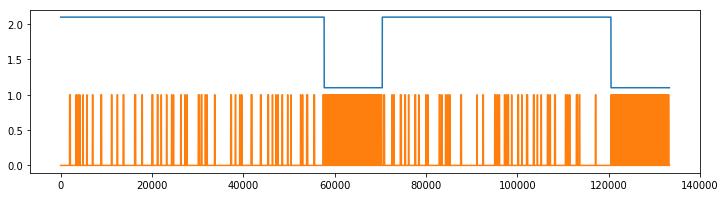

In [11]:
# mask out incorrect trials and target
ctx=xforms.evaluate_step(['nems.xforms.mask_all_but_correct_references',
  {'balance_rep_count': False,
   'include_incorrect': False,
   'generate_evoked_mask': False}], ctx)

plt.figure(figsize=(12,3))
plt.plot(ctx['rec']['state'].as_continuous()[1:2,:].T+1.1)
plt.plot(ctx['rec']['mask'].as_continuous().T)


In [12]:
ctx['rec']['resp'].shape


(28, 133276)

In [13]:
pc_sig='pca'
xfa = ['nems.preprocessing.resp_to_pc', {'pc_idx': pc_idx, 'pc_sig': pc_sig, 'overwrite_resp': False, 'pc_source': pc_source}]
#resp_to_pc(rec, pc_idx=[pc_idx], resp_sig='resp', pc_sig='pca',
#               pc_count=None, pc_source='all', overwrite_resp=True,
#               compute_power='no', whiten=True, **context)

ctx=xforms.evaluate_step(xfa, ctx)
#ctx['rec'][pc_sig].chans=[f'PC_{pc_source}_{pc_idx}']

print(ctx['rec']['resp'].shape)
#print(ctx2['rec']['resp'].chans)
print(ctx['rec']['pca'].shape)

"""
pc_power= np.nanstd(ctx['rec']['pca'].as_continuous(), axis=1)
pc0 = ctx['rec']['resp'].as_continuous()[0,:]
#plt.figure();plt.plot(pc_power);
plt.figure();plt.plot(pc0[:1000]);
plt.ylabel(ctx['rec']['resp'].chans[0])
"""

[nems.xforms INFO] Evaluating: nems.preprocessing.resp_to_pc
[nems.preprocessing INFO] generating PSTHs for 30 epochs


(28, 133276)
(28, 133276)


"\npc_power= np.nanstd(ctx['rec']['pca'].as_continuous(), axis=1)\npc0 = ctx['rec']['resp'].as_continuous()[0,:]\n#plt.figure();plt.plot(pc_power);\nplt.figure();plt.plot(pc0[:1000]);\nplt.ylabel(ctx['rec']['resp'].chans[0])\n"

In [14]:
ctx['rec']['pca'].shape

(28, 133276)

In [15]:
import nems_lbhb.dimensionality_reduction as dr

# ==================  add signal with projection of resp onto the noise axis =============================
r=ctx['rec'].copy()

# remove existing mask
del r.signals['mask']

# mask passive trials, correct trials, miss trials. Keep all ref and target
r = r.and_mask(['PASSIVE_EXPERIMENT', 'HIT_TRIAL', 'MISS_TRIAL'])

# ==================  add signal with projection of resp onto the noise axis =============================
r = dr.get_noise_projection(r, epochs=None, collapse=True)
r = dr.get_discrimination_projection(r, epoch1='TARGET', epoch2='REFERENCE', collapse=True)

ctx['rec']['noise_projection']=r['noise_projection']
ctx['rec']['TARGET_vs_REFERENCE_projection']=r['TARGET_vs_REFERENCE_projection']

ctx['rec'].signals

{'resp': <nems.signal.RasterizedSignal at 0x1c4702c908>,
 'stim': <nems.signal.RasterizedSignal at 0x1c4702cd68>,
 'pupil': <nems.signal.RasterizedSignal at 0x1c4702c4e0>,
 'rem': <nems.signal.RasterizedSignal at 0x1c47005f60>,
 'epoch_onsets': <nems.signal.RasterizedSignal at 0x1c4700b438>,
 'pupil_raw': <nems.signal.RasterizedSignal at 0x1c4700b9e8>,
 'active': <nems.signal.RasterizedSignal at 0x1c4700ba90>,
 'state': <nems.signal.RasterizedSignal at 0x1c4700bc50>,
 'state_raw': <nems.signal.RasterizedSignal at 0x1c47049710>,
 'mask': <nems.signal.RasterizedSignal at 0x1c47049a90>,
 'pca': <nems.signal.RasterizedSignal at 0x1c47063320>,
 'noise_projection': <nems.signal.RasterizedSignal at 0x1c453c7f98>,
 'TARGET_vs_REFERENCE_projection': <nems.signal.RasterizedSignal at 0x1c4706b128>}

['PC0']

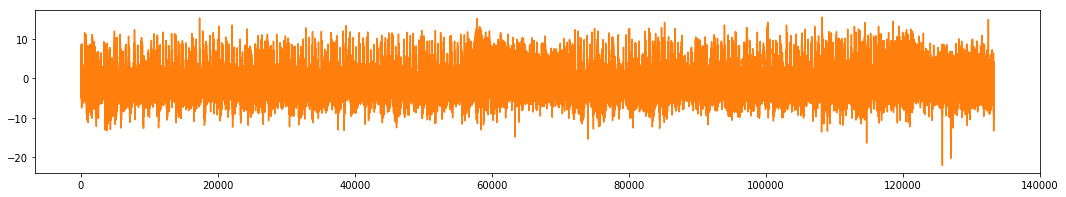

In [16]:
plt.figure(figsize=(18,3))
plt.plot(ctx['rec']['resp'].as_continuous()[0,:])

if projection == "discrim":
    ctx['rec']['resp'] = ctx['rec']['TARGET_vs_REFERENCE_projection']
elif projection == "noise":
    ctx['rec']['resp'] = ctx['rec']['noise_projection']
elif projection == "pc":
    ctx['rec']['resp'] = ctx['rec'][pc_sig].extract_channels(chans=[f'PC{pc_idx}'])
else:
    raise ValueError(f"unknown projection {projection}")
    
plt.plot(ctx['rec']['resp'].as_continuous().T)
ctx['rec']['resp'].chans

In [17]:
ctx=xforms.evaluate_step(['nems.xforms.init_from_keywords', {}], ctx)

ctx['modelspec'].phi

[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.initializers INFO] kw: wc.15x2
[nems.initializers INFO] kw: fir.2x8
[nems.initializers INFO] kw: lvl.1
[nems.initializers INFO] kw: stategain.3
[nems.initializers INFO] kw: lvl.1
[nems.initializers INFO] Setting modelspec[0] input to stim
[nems.utils INFO] model save destination: /Users/svd/python/nems/results/307/TAR010c/ld-norm-st.beh.pup-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-16T183231


[{'coefficients': array([[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
          0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02,
          0.02, 0.02, 0.02, 0.02]])},
 {'coefficients': array([[ 0.  ,  0.1 , -0.05,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.1 , -0.05,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])},
 {'level': array([[0.]])},
 {'g': array([[1., 0., 0.]]), 'd': array([[0., 0., 0.]])},
 {'level': array([[0.]])}]

In [18]:
ctx=xforms.evaluate_step(['nems.xforms.mask_for_jackknife',
  {'allow_partial_epochs': False, 'njacks': 8}], ctx)
ctx=xforms.evaluate_step(['nems.xforms.jack_subset', {'keep_only': 1}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.mask_for_jackknife
[nems.xforms INFO] Evaluating: nems.xforms.jack_subset


In [19]:
fit_init_str='nems.tf.cnnlink.fit_tf_init'
#fit_init_str='nems.tf.cnnlink_new.fit_tf_init'
ctx=xforms.evaluate_step(['nems.xforms.fit_wrapper',
  {'tolerance': 3.162277660168379e-06,
   'norm_fir': False,
   'nl_kw': {},
   'max_iter': 10000,
   'use_modelspec_init': True,
   'optimizer': 'Adam',
   'cost_function': 'squared_error',
   'early_stopping_steps': 5,
   'early_stopping_tolerance': 1e-05,
   'learning_rate': 0.01,
   'distr': 'norm',
   'fit_function': fit_init_str,
   'metric': 'nmse',
   'alpha': 0}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.fit_wrapper
[nems.xforms INFO] ----------------------------------------------------
[nems.xforms INFO] Fitting: nems.tf.cnnlink.fit_tf_init, fit 1/1, fold 1/1
[nems.tf.cnnlink INFO] target_module: ['levelshift', 'relu'] found at modelspec[2].
[nems.tf.cnnlink INFO] Mod 2 (nems.modules.levelshift.levelshift) fixing level to resp mean -1.042
[nems.tf.cnnlink INFO] resp has 1 channels
[nems.tf.cnnlink INFO] Mod 4 (nems.modules.levelshift.levelshift) fixing level to resp mean -1.042
[nems.tf.cnnlink INFO] resp has 1 channels
[nems.tf.cnnlink INFO] nems.modules.weight_channels.basic
nems.modules.fir.basic
nems.modules.levelshift.levelshift
[nems.tf.cnnlink INFO] seed for this fit: 100
[nems.tf.cnnlink INFO] feat_dims: (314, 58, 15)
[nems.tf.cnnlink INFO] data_dims: (314, 58, 1)
[nems.tf.cnnlink INFO] rand seed for intialization: 100
[nems.modelspec INFO] Modelspec2tf: nems.modules.weight_channels.basic
[tensorflow WARNING] From /Users/svd/anaconda/

[nems.tf.cnn INFO] 3420 loss=0.9087168, delta=-0.0000059
[nems.tf.cnn INFO] 5 epochs without significant improvement, stopping early!
[tensorflow INFO] Restoring parameters from /Users/svd/python/nems/results/307/TAR010c/ld-norm-st.beh.pup-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-16T183231/seed100-model.ckpt
[nems.tf.cnnlink INFO] tf2modelspec: nems.modules.weight_channels.basic
[nems.tf.cnnlink INFO] tf2modelspec: nems.modules.fir.basic
[nems.tf.cnnlink INFO] tf2modelspec: nems.modules.levelshift.levelshift
[nems.tf.cnnlink INFO] starting eval_tf. evaluate nems model
[nems.tf.cnnlink INFO] saving nems pred
[nems.tf.cnnlink INFO] generating TF input matrix
[nems.tf.cnnlink INFO] feat_dims: [1, 18212, 15]
[nems.tf.cnnlink INFO] data_dims: [1, 18212, 1]
[nems.modelspec INFO] Modelspec2tf: nems.modules.weight_channels.basic
[nems.modelspec INFO] Modelspec2tf: nems.modules.fir.basic
[nems.modelspec INFO] Modelspec2tf: nems.modules.levelshift.levelshift
[n

In [20]:
fit_str='nems.tf.cnnlink.fit_tf'
#fit_str='nems.tf.cnnlink_new.fit_tf'
ctx=xforms.evaluate_step(['nems.xforms.fit_wrapper',
  {'max_iter': 10000,
   'use_modelspec_init': True,
   'optimizer': 'Adam',
   'cost_function': 'squared_error',
   'fit_function': fit_str,
   'early_stopping_steps': 5,
   'early_stopping_tolerance': 1e-05,
   'learning_rate': 0.01,
   'distr': 'norm'}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.fit_wrapper
[nems.xforms INFO] ----------------------------------------------------
[nems.xforms INFO] Fitting: nems.tf.cnnlink.fit_tf, fit 1/1, fold 1/1
[nems.tf.cnnlink INFO] seed for this fit: 50
[nems.tf.cnnlink INFO] feat_dims: (314, 58, 15)
[nems.tf.cnnlink INFO] data_dims: (314, 58, 1)
[nems.tf.cnnlink INFO] rand seed for intialization: 50
[nems.modelspec INFO] Modelspec2tf: nems.modules.weight_channels.basic
[nems.modelspec INFO] Modelspec2tf: nems.modules.fir.basic
[nems.modelspec INFO] Modelspec2tf: nems.modules.levelshift.levelshift
[nems.modelspec INFO] Modelspec2tf: nems.modules.state.state_dc_gain
[nems.modelspec INFO] Modelspec2tf: nems.modules.levelshift.levelshift
[nems.tf.cnn INFO] Initializing net: setting output, loss, optimizer, globals, tf session
[nems.tf.cnn INFO] Training with batch_size=314, LR=0.01, max_iter=10000, early_stopping_steps=5, early_stopping_tolerance=1e-05, optimizer=Adam.
[nems.tf.cnn INFO] Initial loss

In [21]:
ctx=xforms.evaluate_step(['nems.xforms.predict', {}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.predict


In [22]:
ctx=xforms.evaluate_step(['nems.xforms.add_summary_statistics', {}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.add_summary_statistics
[nems.xforms INFO] Skipping jackknife MI calculations
[nems.metrics.state INFO] state_mod_index for pred, state_raw, baseline
[nems.metrics.state INFO] state_mod_index for pred, state_raw, active
[nems.metrics.state INFO] state_mod_index for pred, state_raw, pupil
[nems.metrics.state INFO] state_mod_index for resp, state_raw, baseline
[nems.metrics.state INFO] state_mod_index for resp, state_raw, active
[nems.metrics.state INFO] state_mod_index for resp, state_raw, pupil


[nems.xforms INFO] Evaluating: nems.xforms.plot_summary
[nems.modelspec INFO] Quickplot: no epoch specified, falling back to "TRIAL"
[nems.modelspec INFO] plotting row 1/7
[nems.modelspec INFO] plotting row 2/7
[nems.modelspec INFO] plotting row 3/7
[nems.modelspec INFO] plotting row 4/7
[nems.modelspec INFO] plotting row 5/7
[nems.modelspec INFO] plotting row 6/7
[nems.modelspec INFO] plotting row 7/7
[nems.modelspec INFO] Quickplot: generated fig with title "Cell: UNKNOWN, Batch: 307, TRIAL #0 ld-norm-st.beh.pup-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n"


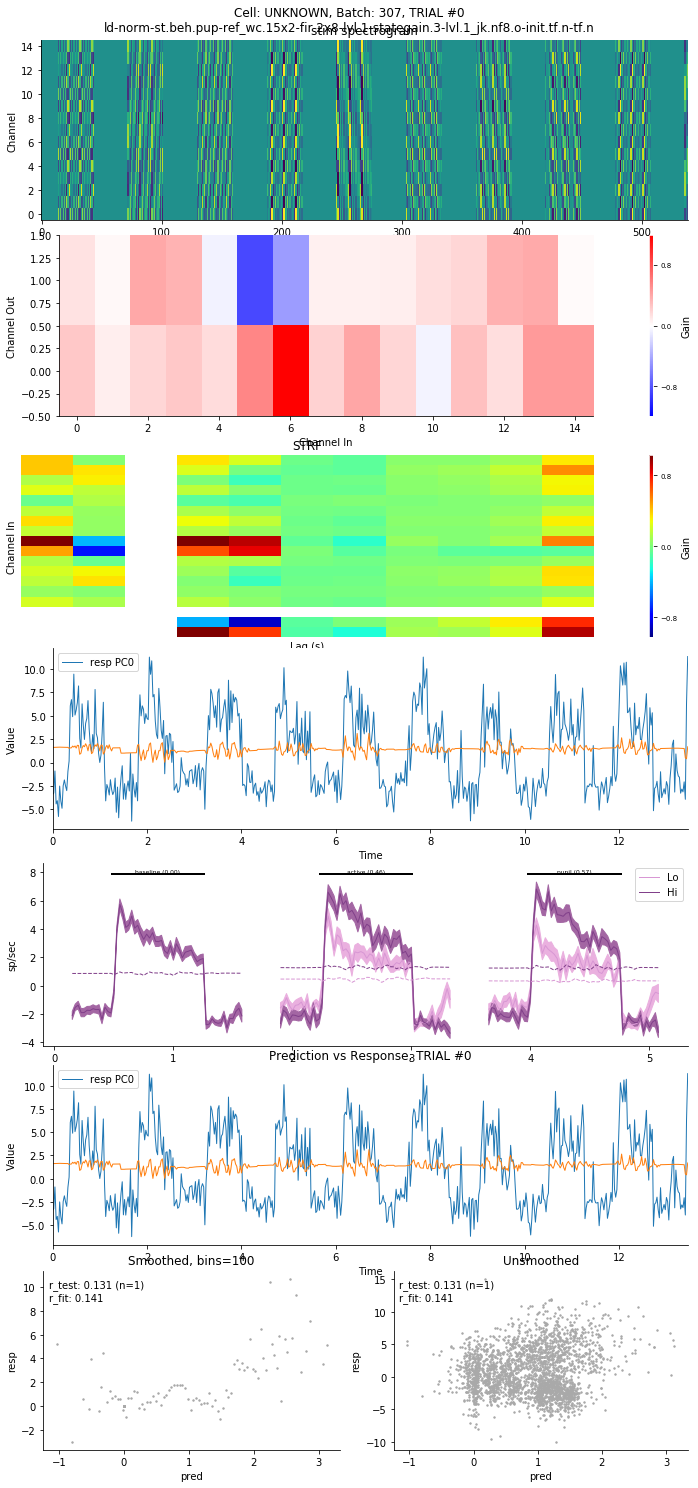

In [23]:
ctx=xforms.evaluate_step(['nems.xforms.plot_summary', {}], ctx)

In [24]:
print(ctx['modelspec'][1]['plot_fns'])
print(ctx['modelspec'][1]['plot_fn_idx'])


['nems.plots.api.mod_output', 'nems.plots.api.spectrogram_output', 'nems.plots.api.strf_heatmap', 'nems.plots.api.strf_local_lin', 'nems.plots.api.strf_timeseries', 'nems.plots.api.fir_output_all']
2


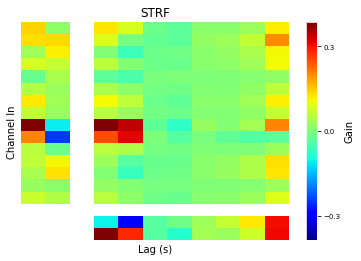

In [80]:
ctx['modelspec'].plot(mod_index=1, plot_fn_idx=2)

prediction correlation: 0.131


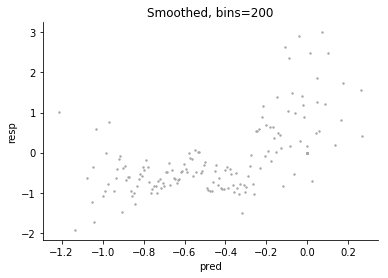

In [88]:
from nems.plots.api import plot_scatter
smoothing_bins=200
plot_scatter(ctx['val']['pred'], ctx['val']['resp'], smoothing_bins=smoothing_bins, title=f'Smoothed, bins={smoothing_bins}')
print(f"prediction correlation: {ctx['modelspec'].meta['r_test'][0][0]:.3f}")
      

In [236]:
ctx['modelspec'].get_longname()

'ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T220504'

### save results ###

In [237]:
modelspec = ctx['modelspec']
meta=modelspec.meta
destination = os.path.join(results_dir, str(batch), xforms.get_meta(ctx)['cellid'],
                           modelspec.get_longname())
print(destination)

/Users/svd/python/nems/results/307/TAR010c-19-1/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T220504


In [238]:
# save to file
log.info('Saving modelspec(s) to {0} ...'.format(destination))
xforms.save_analysis(destination,
                     recording=ctx['rec'],
                     modelspec=modelspec,
                     xfspec=xfspec,
                     figures=ctx['figures'], 
                     log='Empty log')



[__main__ INFO] Saving modelspec(s) to /Users/svd/python/nems/results/307/TAR010c-19-1/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T220504 ...


{'savepath': '/Users/svd/python/nems/results/307/TAR010c-19-1/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T220504/'}

In [239]:
import nems.db as nd
print(nd._get_db_uri())

sqlite:////Users/svd/python/nems/recordings/nems.db


In [240]:
# save summary to a database
log.info('Saving metadata to db  ...')
modelspec.meta['modelpath'] = destination
modelspec.meta['figurefile'] = destination + 'figure.0000.png'
nd.update_results_table(modelspec)


[__main__ INFO] Saving metadata to db  ...


4

### reload the model from db ###

In [211]:
# batch = 307
# cellid = "TAR010c-14-1"
# modelname = "ld-norm-st.beh.pup-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n"
batch, cellid, modelname

(307,
 'TAR010c-27-2',
 'ld-norm-st.beh0.pup0-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n')

In [212]:
# find the results in the database
d=nd.get_results_file(batch=batch, cellids=[cellid], modelnames=[modelname])
filepath = d['modelpath'][0] + '/'
filepath

'/Users/svd/python/nems/results/307/TAR010c-27-2/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T215847/'

In [213]:
# load and display results
xfspec, ctx = xforms.load_analysis(filepath, eval_model=True)


[nems.xforms INFO] Loading xfspec and context from /Users/svd/python/nems/results/307/TAR010c-27-2/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T215847/...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument recording_uri_list overlaps with existing context key: nems.xforms.load_recordings
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.xforms INFO] Extracting cellid(s) TAR010c-14-1
[nems.preprocessing INFO] Adding to epoch_onsets: TRIAL with shift = 0
[nems.xforms INFO] Evaluating: nems.xforms.normalize_sig
[nems.xforms INFO] Evaluating: nems.xforms.normalize_sig
[nems.xforms INFO] Evaluating: nems.xforms.make_state_signal
[nems.xforms INFO] Evaluating: nems.xforms.mask_all_but_correct_references
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.xforms INFO] Evaluating: nems.xforms.mask_for_jackknife
[nems.xforms INFO] Evaluating: nems.xforms.jack_subset
[nems.xf

Get saved data from Results table

In [217]:

modelnames = ["ld-norm-st.beh.pup-ref_" + modelspecname + "_jk.nf8.o-init.tf.n-tf.n",
              "ld-norm-st.beh0.pup0-ref_" + modelspecname + "_jk.nf8.o-init.tf.n-tf.n"]

d = nd.batch_comp(batch=batch, modelnames=modelnames)
d

,ld-norm-st.beh.pup-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n,ld-norm-st.beh0.pup0-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n
cellid,,
TAR010c-14-1,0.042854,NaN
TAR010c-19-1,0.175537,NaN


In [218]:
print(modelname)
print(modelnames[1])

ld-norm-st.beh0.pup0-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n
ld-norm-st.beh0.pup0-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n


Find all models fit for this cell/batch

In [ ]:
d=nd.get_results_file(batch=batch, cellids=[cellid])
d[['cellid','modelname','r_fit','r_test','modelpath']]

### some other inspection stuff ###

Get some basic info about the fit

In [ ]:
print("List of modules in this modelspec:")
print(modelspec)

print("Number of modules: {}".format(len(modelspec)))
print("Number of fits: {}".format(modelspec.fit_count))

Plotting support built in to ModelSpec:

In [ ]:
modelspec[0]['plot_fns']

In [ ]:
modelspec[0]['plot_fn_idx']=1

In [ ]:
modelspec.plot?

In [ ]:
modelspec.plot(mod_index=0, plot_fn_idx=1, rec=ctx['val'])

In [ ]:
modelspec.recording = ctx['val']
print(modelspec[2]['fn'])
modelspec.plot(mod_index=2)

In [ ]:
modelspec.recording = ctx['val']
modelspec[0]['plot_fn_idx']=3
fig=modelspec.quickplot()

In [ ]:
print("Recording views:", ctx['val'].view_count)

# list of views for looping through fit sets (eg, nfold fits)
ctx['val'].views()